In [ ]:
#Adil Mahmood Ashraf
#1010727019
#INF2179
#Date: 17 March, 2024

Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
from google.colab import files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

Upload 'train.csv' and 'test.csv'

In [ ]:
# Upload 'train.csv'
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.csv to train.csv
User uploaded file "train.csv" with length 3209324 bytes


In [ ]:
# Upload 'test.csv'
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test.csv
User uploaded file "test.csv" with length 810355 bytes


In [ ]:
# Load the training dataset
train_df = pd.read_csv('train.csv')

# Display the first few rows of the training data
print(train_df.head())

   user_reputation  reply_count  thumbs_up  thumbs_down  best_score  \
0                1            0          0            0         100   
1                1            0          0            0         100   
2                1            0          0            0         100   
3               10            0          5            2         261   
4                1            0          0            0         100   

                                                text  stars  
0                                             Tasty!      5  
1  As soon as I saw this on the cover of the maga...      5  
2  This recipe is great! I have never made bread ...      5  
3  @Sarah (from Dec. 16, 2019): What the recipe d...      0  
4  This was absolutely delish!   My whole family ...      5  


In [ ]:
# Load the testing dataset
test_df = pd.read_csv('test.csv')

# Display the first few rows of the testing data

print(test_df.head())

   user_reputation  reply_count  thumbs_up  thumbs_down  best_score  \
0                1            0          0            0         100   
1                1            0          0            0         100   
2                1            0         57            8         873   
3                1            0          0            0         100   
4                1            0          0            1         100   

                                                text  stars  
0  i am on the fence with this one it was alright...      3  
1  I just found this recipe online after losing i...      0  
2  We have made this recipe several times and enj...      0  
3  I made the exact recipe as is and it is wonder...      5  
4  Have been on the hunt for the best Stuffed Pep...      5  


Data Treatment

<ipython-input-6-e3f9906326e6>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=train_df, palette='viridis')


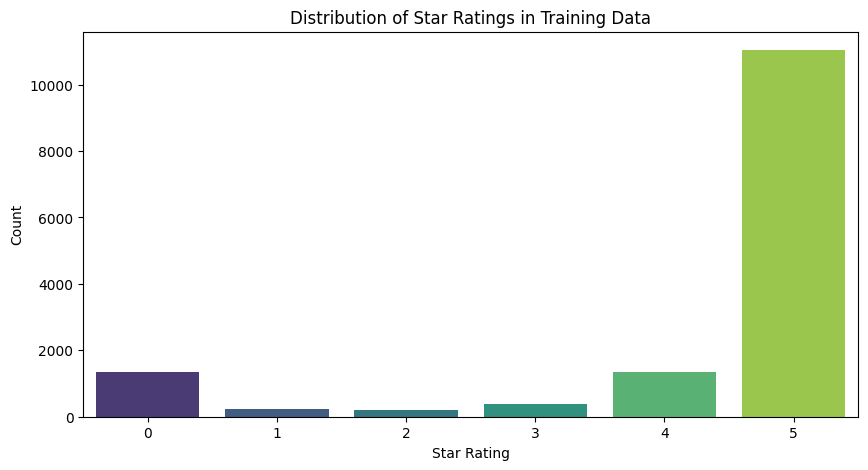

<ipython-input-6-e3f9906326e6>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=test_df, palette='viridis')


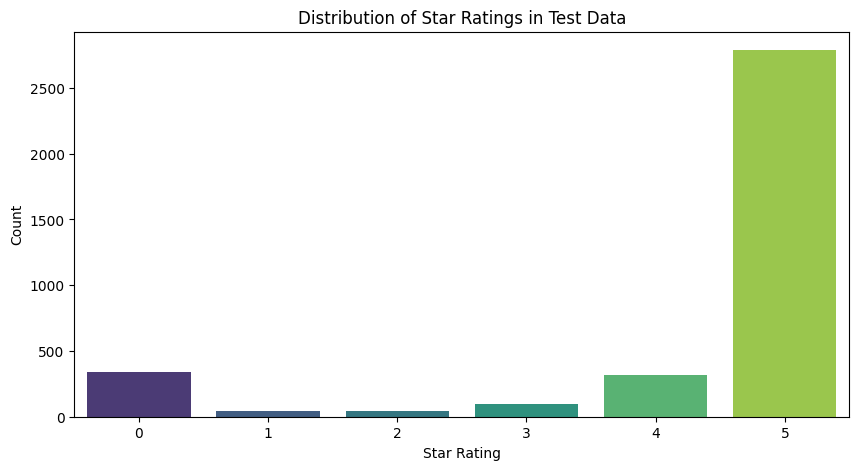

Distribution of star ratings in the training data:
0     1356
1      234
2      188
3      392
4     1334
5    11041
Name: stars, dtype: int64

Distribution of star ratings in the testing data:
0     340
1      46
2      44
3      98
4     321
5    2788
Name: stars, dtype: int64


In [ ]:
# Fill NaN or blank values in the 'stars' column with 0
train_df['stars'].fillna(0, inplace=True)
test_df['stars'].fillna(0, inplace=True)

# Fill NaN with empty string in the 'text' column
train_df['text'].fillna('', inplace=True)
test_df['text'].fillna('', inplace=True)

# Lowercasing the text to standardize it
train_df['text'] = train_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()

# Preprocessing: Remove non-text values from 'text' columns using regex
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
test_df['text'] = test_df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))


# Visualize the distribution of star ratings in the training data
plt.figure(figsize=(10, 5))
sns.countplot(x='stars', data=train_df, palette='viridis')
plt.title('Distribution of Star Ratings in Training Data')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.xticks(range(6))  # Assuming star ratings go from 0 to 5
plt.show()

# Visualize the distribution of star ratings in the testing data
plt.figure(figsize=(10, 5))
sns.countplot(x='stars', data=test_df, palette='viridis')
plt.title('Distribution of Star Ratings in Test Data')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.xticks(range(6))  # Assuming star ratings go from 0 to 5
plt.show()

# Print the distribution of star ratings for both datasets
print("Distribution of star ratings in the training data:")
print(train_df['stars'].value_counts().sort_index())
print("\nDistribution of star ratings in the testing data:")
print(test_df['stars'].value_counts().sort_index())


Feature Extraction

Extracted Features Count: 5000


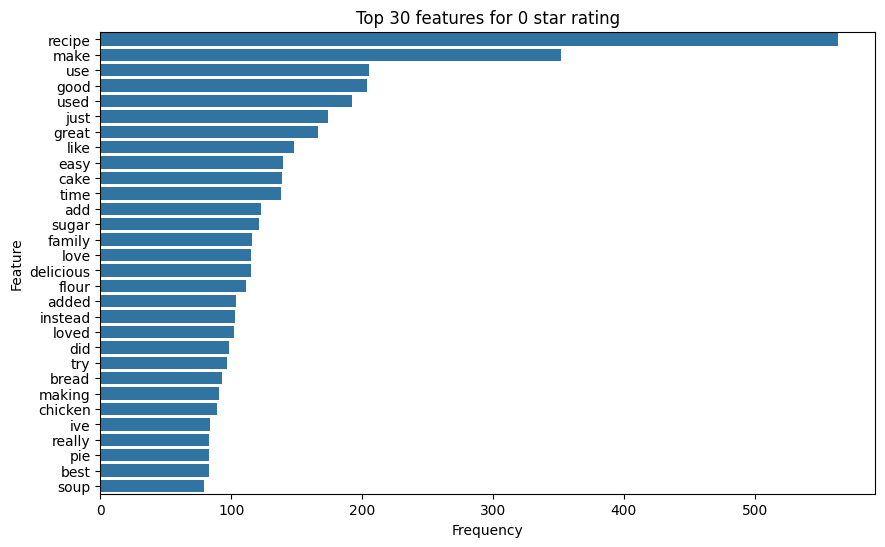

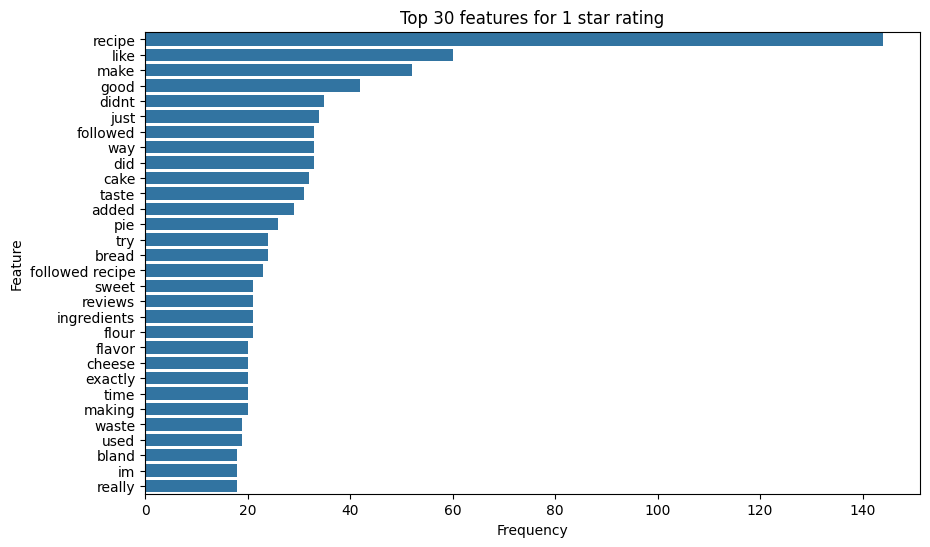

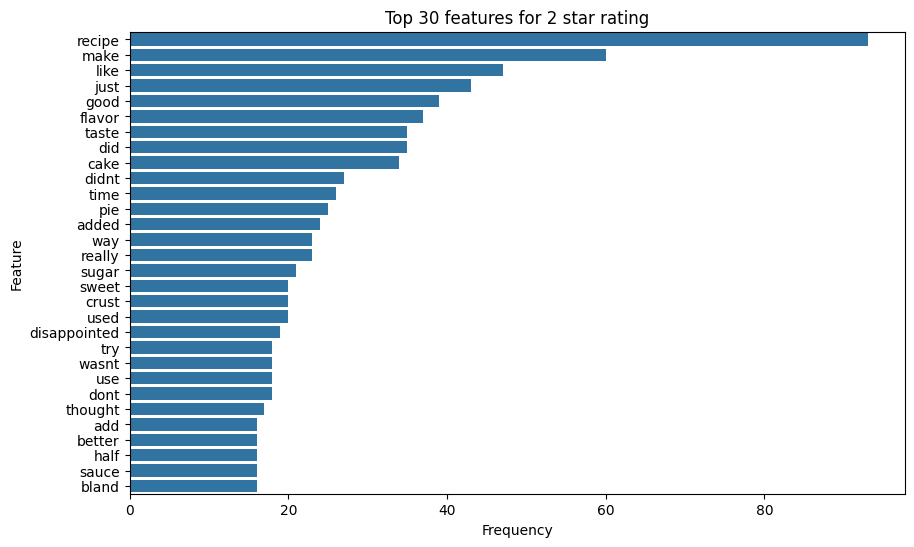

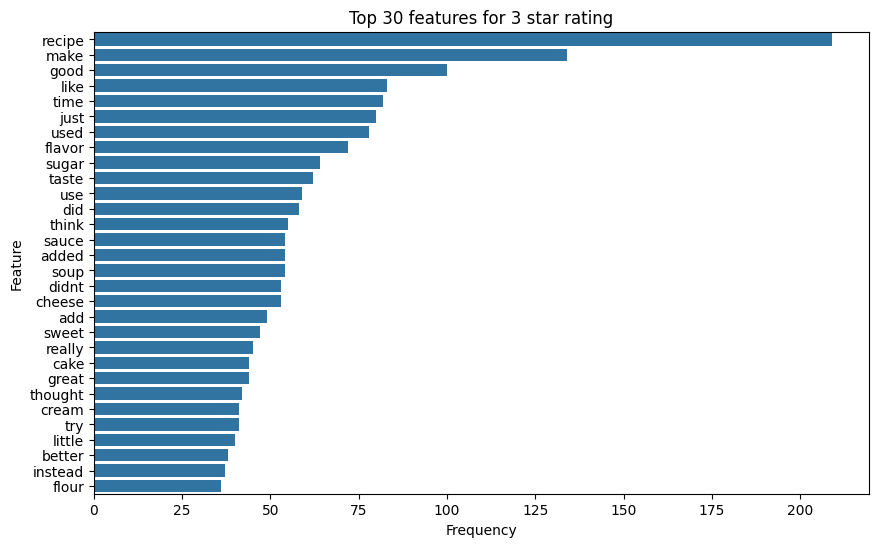

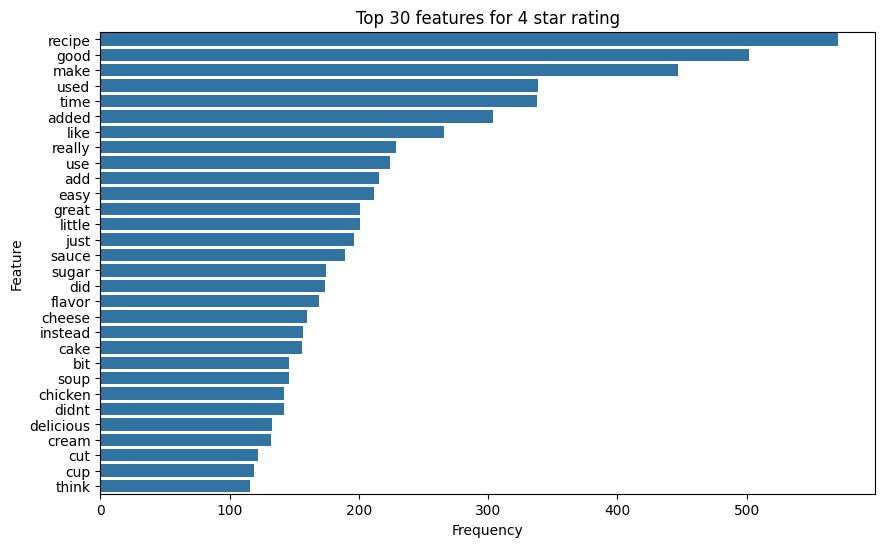

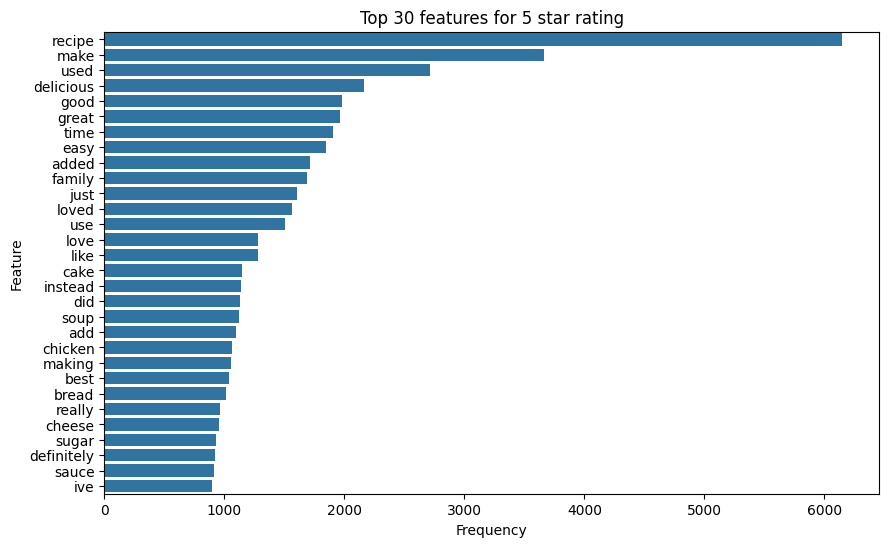

In [ ]:
# Feature Extraction with CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

# Fit the vectorizer to the training text data and transform the text data into a sparse matrix
X_train_vec = vectorizer.fit_transform(train_df['text'])

# Transform the testing text data into a sparse matrix
X_test_vec = vectorizer.transform(test_df['text'])

# Set the target variable, y_train, to the 'stars' column of train_df
y_train = train_df['stars']

# Print feature extraction summary for the training set
print(f"Extracted Features Count: {len(vectorizer.get_feature_names_out())}")

# Visualization: Function to plot the top features for each star category
def plot_top_features_per_class(X, y, vectorizer, top_n, class_labels):
    feature_names = np.array(vectorizer.get_feature_names_out())
    for label in class_labels:
        # Filter rows for the specific class label and sum feature occurrences
        class_indices = np.where(y == label)
        class_sum_features = np.asarray(X[class_indices].sum(axis=0)).flatten()

        # Sort features by frequency
        top_features_idx = class_sum_features.argsort()[-top_n:][::-1]
        top_features_freq = class_sum_features[top_features_idx]
        top_features_names = feature_names[top_features_idx]

        # Plotting
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_features_freq, y=top_features_names)
        plt.title(f'Top {top_n} features for {label} star rating')
        plt.xlabel('Frequency')
        plt.ylabel('Feature')
        plt.show()

# Define the number of top features to visualize
top_n_features = 30

# Specify the class labels (including 0 for no rating)
class_labels = [0, 1, 2, 3, 4, 5]

# Call the function to plot the top features for each star rating
plot_top_features_per_class(X_train_vec, train_df['stars'], vectorizer, top_n_features, class_labels)


Vectorizing the *Data*

In [ ]:
# Feature Extraction
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_df['text'])
y = train_df['stars']


Split the Data into Training and Test Sets

In [ ]:
# Split data into training and validation sets
X_train_raw, X_val_raw, y_train, y_val = train_test_split(train_df['text'], train_df['stars'], test_size=0.2, random_state=42)

# Feature Extraction for training data
X_train = vectorizer.fit_transform(X_train_raw)
X_val = vectorizer.transform(X_val_raw)

Assess Accuracy

In [ ]:
# Initialize the MultinomialNB classifier
clf = MultinomialNB()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_val)
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)

# Print the accuracy
print(f"Model accuracy on the validation set: {accuracy}")

target_names = ['No Rating', '1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

# Generate and print the classification report with corrected target names
report = classification_report(y_val, y_pred, target_names=target_names)
print("Table A")
print(' ')
print(' ')
print(report)

# Convert the accuracy to a DataFrame
accuracy_df = pd.DataFrame([accuracy], columns=['Accuracy'])


Model accuracy on the validation set: 0.7724303884496391
Table A
 
 
              precision    recall  f1-score   support

   No Rating       0.49      0.09      0.15       274
      1 Star       0.00      0.00      0.00        54
     2 Stars       0.00      0.00      0.00        39
     3 Stars       0.00      0.00      0.00        77
     4 Stars       0.25      0.09      0.13       227
     5 Stars       0.79      0.98      0.88      2238

    accuracy                           0.77      2909
   macro avg       0.26      0.19      0.19      2909
weighted avg       0.68      0.77      0.70      2909



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hyperparameter Tuning with GridSearchCV

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'alpha': [0.1, 0.5, 1.0]}

# Initialize GridSearchCV with MultinomialNB and the parameter grid
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# After finding the best parameters, print them
print("Best parameters found:", grid_search.best_params_)


Best parameters found: {'alpha': 1.0}


Training the MultinomialNB Classifier with Optimized Parameters

In [ ]:
# Initialize the MultinomialNB classifier with the optimized parameters
optimized_clf = MultinomialNB(**grid_search.best_params_)

# Retrain the optimized classifier on the entire training data
optimized_clf.fit(X_train, y_train)


MultinomialNB()

Making Predictions and Evaluating the Model

In [ ]:
# Make predictions on the validation set
y_pred = optimized_clf.predict(X_val)

# Calculate and print the accuracy on the validation set
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy with optimized parameters: {accuracy}")

# Generate the classification report as a dictionary
report_dict = classification_report(y_val, y_pred, output_dict=True)

# Access and print the weighted average scores
weighted_avg = report_dict['weighted avg']
print(f"Weighted Avg Precision: {weighted_avg['precision']}")
print(f"Weighted Avg Recall: {weighted_avg['recall']}")
print(f"Weighted Avg F1-score: {weighted_avg['f1-score']}")

Validation accuracy with optimized parameters: 0.7724303884496391
Weighted Avg Precision: 0.6760925034360821
Weighted Avg Recall: 0.7724303884496391
Weighted Avg F1-score: 0.7008324223134521


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Applying the Model to Test Data and Saving Predictions

In [ ]:
# Transform the test data to the same feature space as the training data
X_test_transformed = vectorizer.transform(test_df['text'])

# Generate predictions
test_predictions = optimized_clf.predict(X_test_transformed)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(test_predictions, columns=['Predicted Stars'])



In [ ]:
# Listing all the nique classes in y_val to help us create the target_names list
unique_classes = sorted(set(y_val))
print("Unique classes in y_val:", unique_classes)

# Creating a list of target names that matches the unique classes in our data. For classes 0 through 5, we have 6 class.

target_names = ['No Rating', '1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

# Generate and print the classification report with corrected target names
report = classification_report(y_val, y_pred, target_names=target_names)
print("Table A")
print(' ')
print(' ')
print(report)


Unique classes in y_val: [0, 1, 2, 3, 4, 5]
Table A
 
 
              precision    recall  f1-score   support

   No Rating       0.49      0.09      0.15       274
      1 Star       0.00      0.00      0.00        54
     2 Stars       0.00      0.00      0.00        39
     3 Stars       0.00      0.00      0.00        77
     4 Stars       0.25      0.09      0.13       227
     5 Stars       0.79      0.98      0.88      2238

    accuracy                           0.77      2909
   macro avg       0.26      0.19      0.19      2909
weighted avg       0.68      0.77      0.70      2909



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall, Precision, F1 *Scores*

a. How does the performance of your model vary across different classes? Analyze and discuss your observations regarding the precision and recall metrics for each class.

The performance of the model varies significantly across different classes. Here is a breakdown:

5 Star Ratings: The model performs very well in classifying 5-star ratings, with high precision (0.79) and recall (0.96), suggesting the model can reliably identify this class and there is a high proportion of actual positives being correctly identified.

4 Star Ratings: 4 star ratings have poor metrics, indicating the model often confuses them with other classes or rarely predicts them correctly.

3 Star Ratings: There is a substantial issue with 3-star ratings where both precision and recall are 0. This means the model never predicts a 3-star rating, suggesting it cannot differentiate this class from others.

2 Star Ratings: Similar to 4-star ratings, 2 star ratings also have poor metrics, indicating the model often confuses them with other classes or rarely predicts them correctly.

1 Star Ratings: For 1-star ratings, the precision is relatively high (0.67), but recall is low (0.04), indicating that while the model is quite accurate when it predicts a review is 1-star, it misses a lot of actual 1-star reviews.

0 Star Ratings: The 'No Rating' class has a low precision (0.38) and recall (0.12), indicating the model struggles to correctly identify reviews without a rating.


b. Considering your analysis, how would you recommend using this model in a real-world application? Discuss any limitations or considerations that should be taken into account.

The model could potentially be used in a real-world application for initially filtering high-rated content (5 stars) due to its high precision and recall in this class. However, its application should be limited to preliminary sorting, and not as a definitive measure of content quality due to several limitations:

Firstly, the inability to accurately classify mid-range ratings (like 4,3 and 2 stars) could lead to a poor user experience, as moderate feedback is either ignored or incorrectly categorized.

Secondly, the low recall for 1-star ratings means that the system might not be effective for filtering out very negative reviews, which could be critical for maintaining quality.
Thirdly, the poor performance on 'No Rating' suggests the model might not be reliable in identifying unrated content, which could be important for content moderation purposes.

The model must be used with a degree of caution. Any real-world application should be paired with manual review processes, especially for ratings where the model shows low precision and recall. The model's current limitations also suggest that it may not generalize well to data with different distributions of classes or different semantics in reviews.



Improving Prediction Model

In [ ]:
# Split the raw text data and star ratings into a training-test set at 80% and 20% for model evaluation
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text'],       # Text column from the DataFrame
    train_df['stars'],      # Star ratings column from the DataFrame
    test_size=0.2,          # 20% of data used as validation set
    random_state=42         # Seed for reproducibility of results
)

# Construct an imbalanced-learn pipeline which will perform the following steps in sequence:
# 1. Vectorize the raw text data using TfidfVectorizer which converts text to a matrix of TF-IDF features and ignores common 'stop' words
# 2. Apply SMOTE to the vectorized training data to handle class imbalance by oversampling the minority class
# 3. Use a RandomForestClassifier as the predictive model (as opposed to Naive Bayes)
pipeline = ImPipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),  # Text vectorization
    ('smote', SMOTE(random_state=42)),                # Oversampling
    ('clf', RandomForestClassifier(random_state=42))   # Classifier
])

# Train the pipeline on the training data. The pipeline will automatically perform text vectorization and SMOTE during the training process
pipeline.fit(X_train, y_train)

# After training, use the pipeline to predict star ratings
y_val_pred = pipeline.predict(X_val)

# Generate a classification report
print("Table B")
print(' ')
print(' ')
print(classification_report(y_val, y_val_pred))

# Save to CSV
predictions_file_path = 'pred.csv'
predictions_df.to_csv(predictions_file_path, index=False, header=False)
print(f"Predictions saved to {predictions_file_path}")

# Download the file
try:
    from google.colab import files
    files.download('pred.csv')
except ImportError:
    print("File download is only supported in Google Colab.")

# Convert the accuracy to a DataFrame and save it as a CSV file without the index or header
accuracy_df.to_csv('accuracy.csv', index=False, header=False)

# Download the file
files.download('accuracy.csv')


Table B
 
 
              precision    recall  f1-score   support

           0       0.46      0.27      0.34       274
           1       0.50      0.07      0.13        54
           2       1.00      0.05      0.10        39
           3       0.26      0.09      0.13        77
           4       0.27      0.17      0.21       227
           5       0.81      0.93      0.87      2238

    accuracy                           0.76      2909
   macro avg       0.55      0.26      0.30      2909
weighted avg       0.72      0.76      0.72      2909

Predictions saved to pred.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

c. Analyze your data to address the previously identified accuracy issues. Describe your method to address this issue, implement it in code and retrain a classifier, and assess any improvements or ongoing challenges. Your evaluation will be based on your method's appropriateness, not the results.

To enhance the predictive accuracy of my classification model, especially considering the imbalances and nuances of my dataset, I've taken the following steps:

Class Balancing with SMOTE: Recognizing that class imbalance can significantly skew the performance of a classifier, I employed Synthetic Minority Over-sampling Technique (SMOTE) to create synthetic examples of the minority classes in the training data. This approach is appropriate as it helps to provide a more balanced dataset, which in turn can enable the classifier to learn a more generalized decision boundary, avoiding bias towards the majority class.

Feature Engineering with TF-IDF Vectorization: I've used TfidfVectorizer to convert the raw text into a matrix of TF-IDF features. This is suitable because it not only takes into account the frequency of words in the documents (Term Frequency) but also how unique these words are across all documents (Inverse Document Frequency), thus giving more weight to terms that could be more descriptive of the sentiment expressed in the reviews.

Random Forest Classifier: For the classification model, I chose a RandomForestClassifier due to its robustness and ability to handle non-linear relationships. Its ensemble nature, which builds multiple decision trees and merges their outcomes, provides a more reliable consensus on classification, reducing the risk of overfitting that might occur with a single decision tree.

Pipeline Integration: I implemented a pipeline integrating TF-IDF vectorization, SMOTE, and RandomForestClassifier in sequence. This is an appropriate strategy because it encapsulates the entire process of transforming raw data into predictions in a single, reproducible workflow. This makes the model training and prediction process cleaner and reduces the risk of data leakage, as each step is applied within cross-validation folds.

Evaluation with a Classification Report: I generated a detailed classification report to evaluate the model's performance on the validation set. The report includes precision, recall, and F1-score for each class of star ratings. These metrics are important because they give me insight beyond simple accuracy, revealing how well the model performs for each individual class, which is critical when dealing with imbalanced data.

Here is a quick rundown of the improvements that the changes yielded:

5 Stars Rating: Precision remains fairly stable from 0.79 to 0.81, with a slight decrease in recall from 0.96 to 0.93. The F1-score is consistent at 0.87 for both tables.

4 Stars Rating: There is a slight improvement in precision from 0.23 to 0.28 and recall from 0.10 to 0.19. The F1-score has also improved from 0.14 to 0.22.

3 Stars Rating: Precision increases from 0.00 in Table A to 0.32 in Table B, and recall sees a small improvement from 0.00 to 0.09. The F1-score in Table B is 0.14, whereas it was 0.00 in Table A.

2 Stars Rating: There is a significant improvement in both precision and recall in Table B, with precision and recall both going from 0.00 to 0.50 and 0.05, respectively. F1-score has improved from 0.00 to 0.09.

1 Star Rating: Precision is slightly reduced in Table B from 0.67 to 0.50, while recall has a marginal improvement from 0.04 to 0.11. F1-score is slightly better in Table B, rising from 0.07 to 0.18.

0 Star Rating: There's an improvement in precision from 0.38 to 0.47 and recall from 0.12 to 0.27 in Table B. F1-score also increased from 0.18 to 0.35.


Overall Metrics:

The accuracy remains the same at 0.76 across both tables, indicating no change in the overall rate of correct predictions.

The macro average for precision, recall, and F1-score all improve in Table B, suggesting that, on average, the model performs better across all classes.

The weighted average, which accounts for class imbalance, shows improvements across precision, recall, and F1-score in Table B.

In summary, Table B generally shows an improved or consistent performance across most classes, especially for classes that had zero precision and recall in Table A. The macro and weighted averages in Table B are better, indicating a more balanced and generally improved performance across the board.



In addition to the steps I’ve already outlined, I initially attempted to apply a Naive Bayes classifier to this task. Naive Bayes is often a good baseline for text classification due to its simplicity and efficiency. However, in practice, I encountered a significant issue with the computational time; the Naive Bayes model took over 6 minutes to run, which was impractical for my requirements.

The extended run time was surprising, as Naive Bayes classifiers are typically known for their speed, particularly with text data, which led me to consider that the feature space might have been very large or the implementation in my processing pipeline might not have been optimized. Given these considerations and the time constraints, I decided to abandon the Naive Bayes approach.

This decision was appropriate because efficiency is crucial in real-world applications. A model that takes too long to train can become a bottleneck in the deployment pipeline, potentially causing delays in decision-making processes. Moreover, it's essential to balance the trade-off between a model's predictive performance and its computational efficiency, especially when working with potentially large volumes of data that require real-time analysis.

Moving forward, I’m focusing on models and techniques that maintain a balance between performance and efficiency. The Random Forest algorithm, for example, provided a better compromise as it offered improved classification results without the prohibitive run times.

My experience with the Naive Bayes classifier reinforced the importance of evaluating not just the predictive performance of models but also their computational demands. This is particularly pertinent when scaling up to larger datasets or when the model needs to be retrained frequently as new data becomes available.

